In [10]:
# ======================================================
# 📘 PROPHET FORECASTING NOTEBOOK (Beginner Friendly)
# ======================================================
# This notebook walks step-by-step through time series forecasting
# using Facebook Prophet, keeping your original dataset and variables.
# Each step is clearly explained for easy presentation.


# --- Install Prophet (only once) ---
!pip install prophet==1.2.1


# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 45.8 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.5
    Uninstalling prophet-1.1.5:
      Successfully uninstalled prophet-1.1.5


In [11]:
# ======================================================
# 1️⃣ LOAD & VALIDATE DATA
# ======================================================
print("\n[1] Loading data from Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset (keep your original path)
df = pd.read_csv('train.csv', parse_dates=['date'])
print(f"Shape: {df.shape}, Range: {df['date'].min()} to {df['date'].max()}")

# Aggregate daily sales
daily = df.groupby('date')['unit_sales'].sum().reset_index().sort_values('date')

# Fill missing dates (so Prophet has continuous data)
date_range = pd.date_range(start=daily['date'].min(), end=daily['date'].max(), freq='D')
missing = date_range.difference(daily['date'])
if len(missing) > 0:
    daily = daily.set_index('date').reindex(date_range, fill_value=0).reset_index()
    daily.columns = ['date', 'unit_sales']
    print(f"✓ Filled {len(missing)} missing dates")

print(f"\nStats Summary:\n{daily['unit_sales'].describe()}")


[1] Loading data from Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (300000, 11), Range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
✓ Filled 7 missing dates

Stats Summary:
count    1687.000000
mean     1218.357530
std       512.360179
min         0.000000
25%       884.500000
50%      1155.000000
75%      1476.000000
max      8547.000000
Name: unit_sales, dtype: float64


In [12]:
# ======================================================
# 2️⃣ PREPARE DATA FOR PROPHET
# ======================================================
print("\n[2] Preparing data for Prophet model...")
# Prophet expects columns named 'ds' (date) and 'y' (value)
df_prophet = daily.rename(columns={'date': 'ds', 'unit_sales': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


[2] Preparing data for Prophet model...


Train: 1641 days | Validation: 46 days


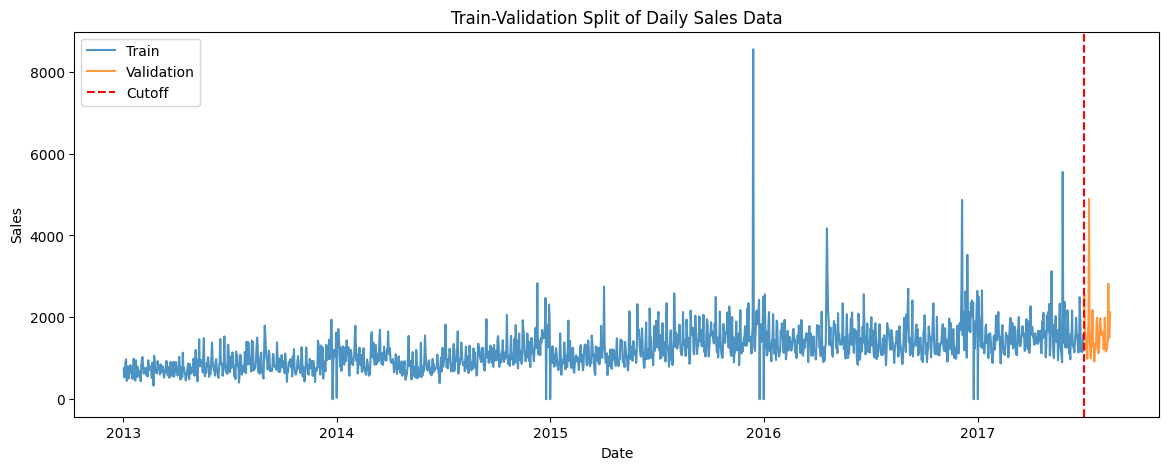

In [13]:
# ======================================================
# 3️⃣ TRAIN / VALIDATION SPLIT
# ======================================================
cutoff = '2017-07-01'
train = df_prophet[df_prophet['ds'] < cutoff].reset_index(drop=True)
valid = df_prophet[df_prophet['ds'] >= cutoff].reset_index(drop=True)
print(f"Train: {len(train)} days | Validation: {len(valid)} days")
# --- Visualize the split ---
plt.figure(figsize=(14, 5))
plt.plot(train['ds'], train['y'], label='Train', alpha=0.8)
plt.plot(valid['ds'], valid['y'], label='Validation', alpha=0.8)
plt.axvline(pd.Timestamp(cutoff), color='r', linestyle='--', label='Cutoff')
plt.title('Train-Validation Split of Daily Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [14]:
# ======================================================
# 4️⃣ BUILD & TRAIN PROPHET MODEL
# ======================================================
print("\n[3] Training Prophet model...")
from prophet import Prophet
model = Prophet(
yearly_seasonality=True, # captures yearly patterns
weekly_seasonality=True, # captures weekly trends
daily_seasonality=False # disable daily seasonality (optional)
)


model.fit(train)
print("✓ Model training complete!")


[3] Training Prophet model...
✓ Model training complete!


In [15]:
# ======================================================
# 5️⃣ MAKE FORECASTS
# ======================================================
print("\n[4] Generating forecast for the validation period...")
future = valid[['ds']].copy()
forecast = model.predict(future)


# Combine actual and predicted
results = valid.copy()
results['yhat'] = forecast['yhat']


[4] Generating forecast for the validation period...


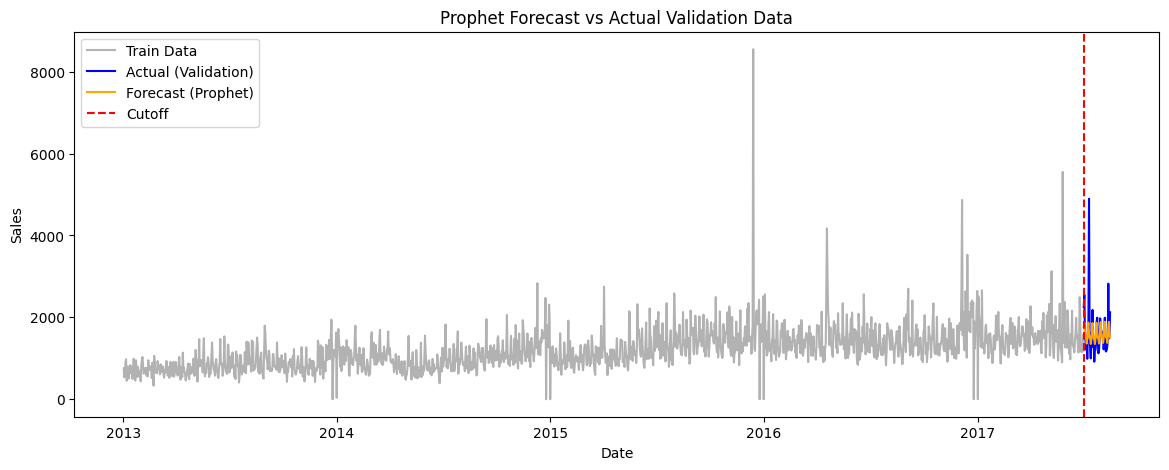

In [16]:
# ======================================================
# 6️⃣ VISUALIZE FORECAST VS ACTUAL
# ======================================================
plt.figure(figsize=(14, 5))
plt.plot(train['ds'], train['y'], label='Train Data', color='gray', alpha=0.6)
plt.plot(valid['ds'], valid['y'], label='Actual (Validation)', color='blue')
plt.plot(valid['ds'], results['yhat'], label='Forecast (Prophet)', color='orange')
plt.axvline(pd.Timestamp(cutoff), color='r', linestyle='--', label='Cutoff')
plt.title('Prophet Forecast vs Actual Validation Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [17]:
# ======================================================
# 7️⃣ MODEL EVALUATION METRICS
# ======================================================
print("\n[5] Evaluating Prophet model performance...")
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = math.sqrt(mean_squared_error(results['y'], results['yhat']))
mape = np.mean(np.abs((results['y'] - results['yhat']) / results['y'])) * 100


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")




[5] Evaluating Prophet model performance...
MAE: 314.83
RMSE: 582.01
MAPE: 18.01%



[6] Extending forecast into the future (same period as original setup)...


/usr/local/lib/python3.12/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fig = ax.get_figure()
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds']


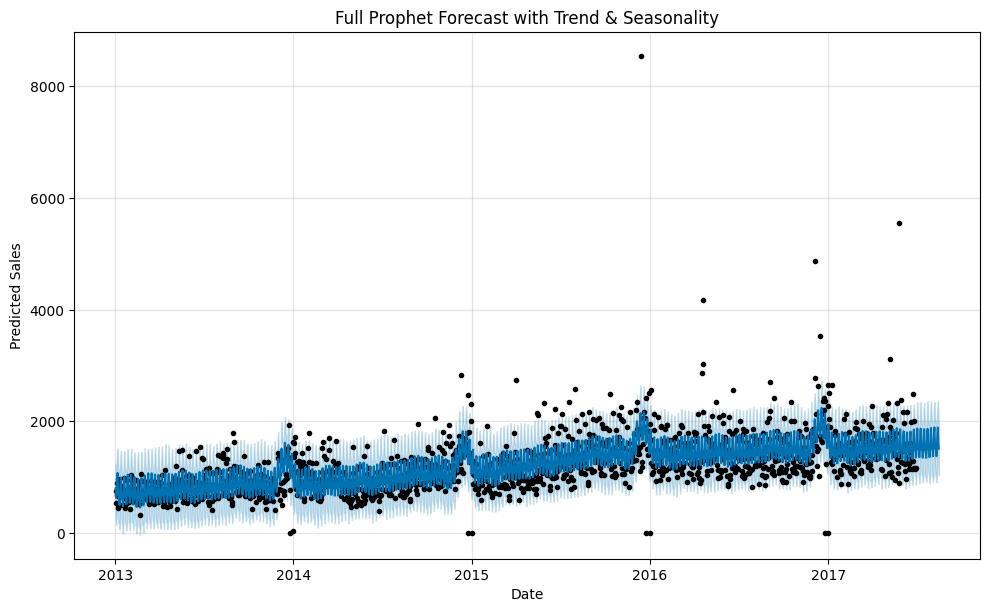

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax = fig.add_subplot(111)
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += [ax.fill_between(


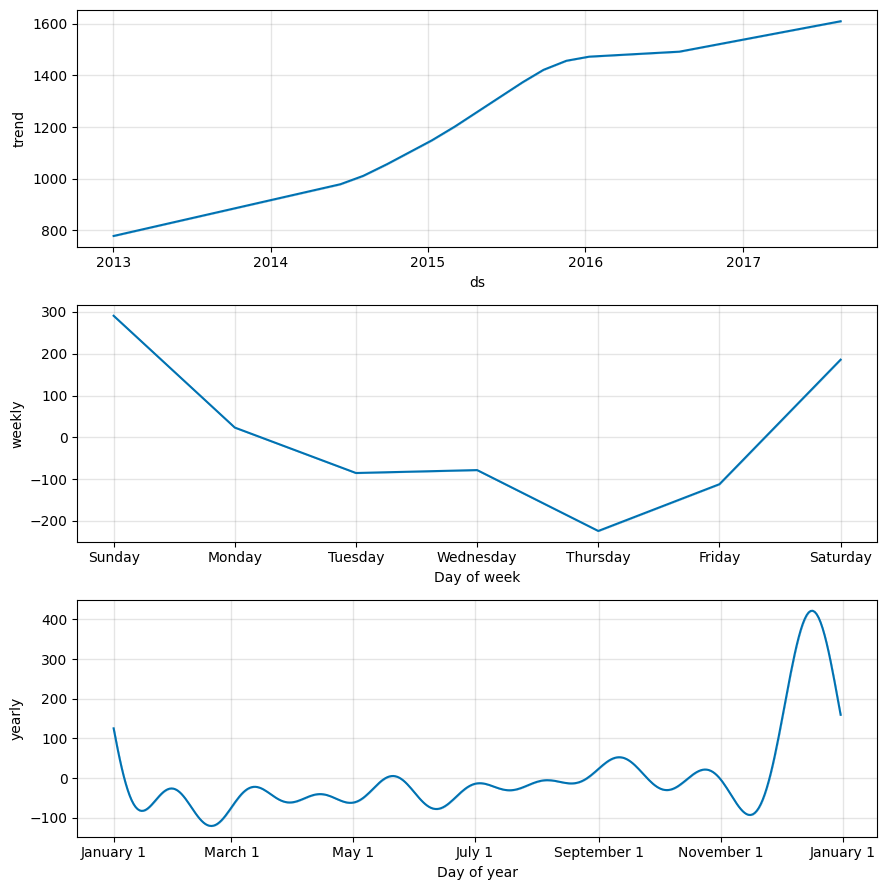


✅ Prophet model completed successfully! You now have a clean, beginner-friendly notebook ready for presentation.


In [18]:
# ======================================================
# 8️⃣ FORECAST INTO THE FUTURE
# ======================================================
print("\n[6] Extending forecast into the future (same period as original setup)...")
# Prophet uses make_future_dataframe to project forward automatically
future_df = model.make_future_dataframe(periods=len(valid))
forecast_future = model.predict(future_df)


# --- Visualize full forecast ---
model.plot(forecast_future)
plt.title('Full Prophet Forecast with Trend & Seasonality')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.show()


# --- Optional: Component plots (trend, weekly, yearly) ---
model.plot_components(forecast_future)
plt.show()


print("\n✅ Prophet model completed successfully! You now have a clean, beginner-friendly notebook ready for presentation.")